# Introduction to Convolutional Nets

- This is Part-2 of our image recognition study. Here, we will build a simple CNN model. In addition to Part-1, we added few more functions to visualize CNN filters and feature maps. This is a great demonstration to see why even a simple CNN model outperforms FNN model in vision tasks. **Please have a look at our lecture notes on CNNs before reading this notebook.**


- Most of the sections are exactly the same with the FNN notebook, except the fact that we will build a CNN model here. Thus, refer to it whenever you need to remember something.

- For the functions we imported from "utils", I explicitly state all the arguments so that you can easily see how you can modify it.

## Import necessary modules

In [1]:
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import os
from torchinfo import summary
import warnings
warnings.filterwarnings('ignore') 
#===custom functions===========#
from utils import get_data_paths,view_samples,view_class_dist,seed_everything
from utils import train_test_model,load_model
from utils import display_predictions, get_confusion_matrix,plot_confusion_matrix,get_scores,display_misclassified_images,display_all_scores
from utils import get_all_feature_maps,visualize_feature_maps


#make sure to have GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
#make your code reproducible
seed_everything()

NVIDIA GeForce RTX 2070 Super
NVIDIA GeForce RTX 2070 Super


## Loading the Data via Pytorch DataLoader

In [2]:
train_dir = "snicker_data/train/"
test_dir =  "snicker_data/test"
train_image_paths,test_image_paths = get_data_paths(train_dir, test_dir)

In [3]:
#resize the images
width = 60
height = 60

#define necessary transforms to be applied to each batch. conversion to tensor is bare minimum
training_transforms = transforms.Compose([transforms.Resize((width,height)),
                                          transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((width,height)),
                                      transforms.ToTensor()])


train_set = datasets.ImageFolder(train_dir, transform = training_transforms)
test_set  = datasets.ImageFolder(test_dir, transform = test_transforms)

#this is what is loaded in each batch
batch_size = 16
train_loader = DataLoader(train_set,batch_size = batch_size,shuffle=True)
test_loader = DataLoader(test_set,batch_size = batch_size)

In [4]:
class_list = train_set.classes
class_to_idx = train_set.class_to_idx
print(class_to_idx)
idx_to_class = {i:j for i, j in enumerate(class_list)}
num_classes = len(class_list)
class_counts = torch.bincount(torch.tensor(train_set.targets)).tolist()

print(class_counts)

{'adidas': 0, 'converse': 1, 'new-balance': 2, 'nike': 3, 'reebok': 4, 'vans': 5}
[90, 98, 92, 95, 95, 93]


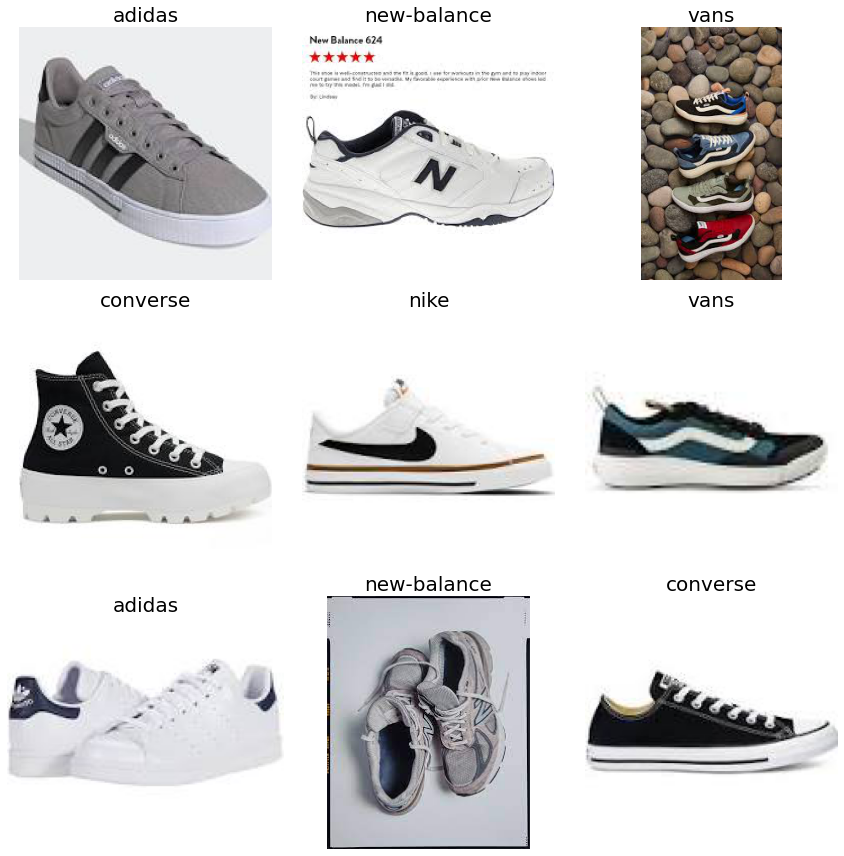

In [5]:
#view some samples in nxn grid
view_samples(n=3,img_paths=train_image_paths)

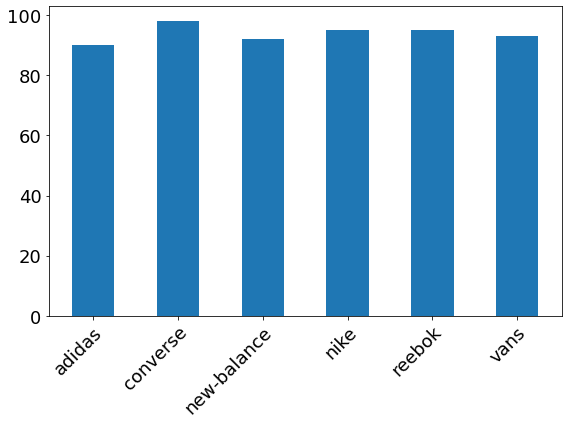

In [6]:
#check the class distribution
view_class_dist(class_list=class_list,class_counts=class_counts)

# Build a Convolutional Neural Network(CNN) Architecture 

- Now, we will build a custom CNN model. In the model, we will have 128,64,32 and 16 convolutional layer(feature maps) followed by a fully connected layer with 64 neurons. Such an order is very common in practice.
- A typical CNN layer is followed by activation function, then [Batch Normalization](https://www.youtube.com/watch?v=dXB-KQYkzNU) and then [Pooling](https://www.youtube.com/watch?v=ZjM_XQa5s6s) operation. Click on the links to learn more about these items. 
- Instead of writing the same structure again over again, we can simply define two functions returning such structures and call them one after another. However, one can achieve the same task by defining each of these items one by one. I include both down there;

In [7]:
#nice way of building a model using Pytorch containers
def Get2dConv(in_channels,out_channels):
    
    return nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(out_channels),
                        nn.MaxPool2d(kernel_size=2,stride=2)
                        )
def GetLinear(in_features,out_features):
    
    return nn.Sequential( nn.Linear(in_features,out_features),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm1d(out_features)
                      )

# Extent nn.Module to create a new model.
class SnickerModel(nn.Module):
    def __init__(self):
        super(SnickerModel,self).__init__()
        self.conv1 = Get2dConv(3,32)
        self.conv2 = Get2dConv(32,32)
        self.conv3 = Get2dConv(32,64)
        
        self.fc1 = GetLinear(64*5*5,128)
        
        self.out = nn.Linear(in_features=128,out_features=num_classes)
     
    
    def forward(self, t):
        t = self.conv1(t)
        t = self.conv2(t)
        t = self.conv3(t)
        
       

        t = torch.flatten(t,1)

        t = self.fc1(t)
        t = self.out(t)
       
        return t

In [8]:
model = SnickerModel()
summary(model,input_size=(batch_size,3,width,height))

Layer (type:depth-idx)                   Output Shape              Param #
SnickerModel                             [16, 6]                   --
├─Sequential: 1-1                        [16, 32, 29, 29]          --
│    └─Conv2d: 2-1                       [16, 32, 58, 58]          896
│    └─ReLU: 2-2                         [16, 32, 58, 58]          --
│    └─BatchNorm2d: 2-3                  [16, 32, 58, 58]          64
│    └─MaxPool2d: 2-4                    [16, 32, 29, 29]          --
├─Sequential: 1-2                        [16, 32, 13, 13]          --
│    └─Conv2d: 2-5                       [16, 32, 27, 27]          9,248
│    └─ReLU: 2-6                         [16, 32, 27, 27]          --
│    └─BatchNorm2d: 2-7                  [16, 32, 27, 27]          64
│    └─MaxPool2d: 2-8                    [16, 32, 13, 13]          --
├─Sequential: 1-3                        [16, 64, 5, 5]            --
│    └─Conv2d: 2-9                       [16, 64, 11, 11]          18,496
│    └─

- In each conv2d-RelU-BatchNorm-MaxPool block, here is what happens:

**(1) Apply convolution**

&rarr; input = in_channel x H x W

&rarr; filter_size = out_channel X in_channel x Kernel x Kernel 

&rarr; conv_output = out_channel X H_c x W_c

**(2) apply ReLU and batch normalization**

**(3) apply pooling layer**

&rarr; pooling_filter_size = out_channel x pool_kernel x pool_kernel 

&rarr; pool_output = out_channel x H_p X W_p


- For example, lets look at the first block

(1)  apply convolution

&rarr; input = 3 x 128 x 128

&rarr; filter_size = 32 x 3 x 3 x 3 **(these are the parameters we learn!)**

&rarr; conv_output = 32 x 126 x 126

(2) apply ReLU and batch normalization(no size change)

(3) apply pooling layer

&rarr; pooling_filter_size = 32 x 2 x 2

&rarr; pool_output = 32 x 63 x 63

# Training and Testing


This is our driver function to train-test our model. Function arguments are self-explanatory. Notice that we have only 234K 

In [19]:
model = SnickerModel()
num_epochs = 20
lr = 2e-3
log_int = 5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model_name = "best_cnn"
train_test_model(model, train_loader, test_loader, optimizer, num_epochs,log_int,model_name)

epoch:5/20 train_acc: 67.7%, testing_acc: 38.0%
epoch:10/20 train_acc: 97.0%, testing_acc: 47.9%
epoch:15/20 train_acc: 87.9%, testing_acc: 50.7%
epoch:20/20 train_acc: 92.7%, testing_acc: 55.6%
best testing accuracy: 58.45 train time: 12.3sec


# Evaluate the Model Performance

First let's load the saved model and use it to evaluate our model performance

In [20]:
#this will reload the model with 'learned parameters'
model = SnickerModel()
model = load_model(model,"best_cnn.pth")
model.best_scores

{'BestTestAcc': 0.5845070422535211, 'lr': 0.002}

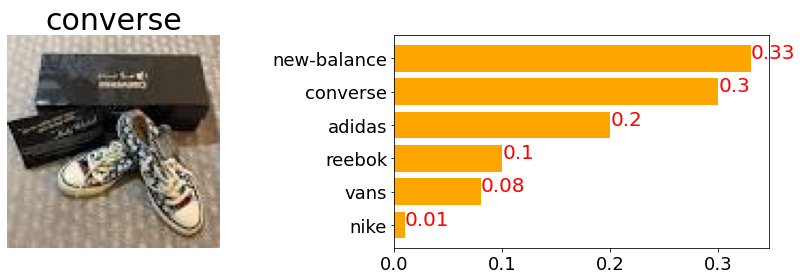

In [21]:
display_predictions(model=model,img_paths=test_image_paths,n=1,topk=num_classes,
                test_transforms=test_transforms,idx_to_class=idx_to_class)

- Check which images are misclassified by the model.These are the confusing images for the model.

top2_accuracy: 69.01%


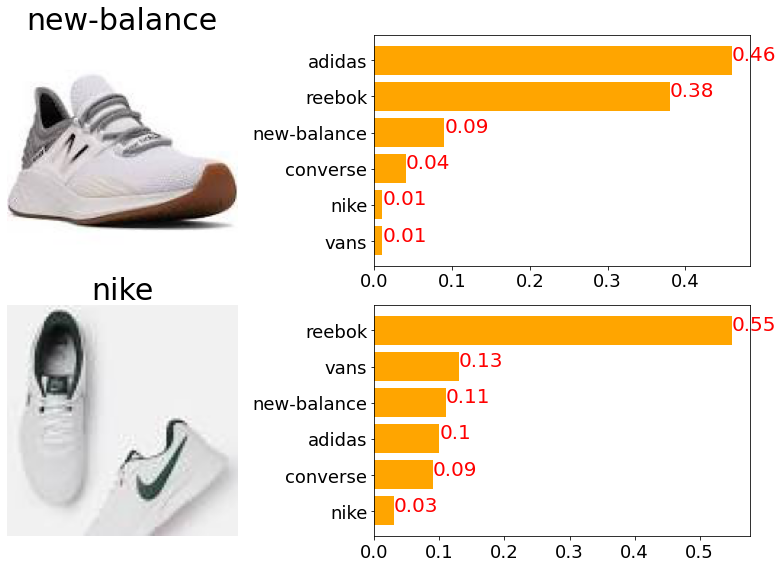

In [12]:
display_misclassified_images(model=model,test_image_paths=test_image_paths,
                           n=2,topk=num_classes,test_transforms=test_transforms,idx_to_class=idx_to_class)

## Confusion Matrix

- The most important outcome of a classification problem is the confusion matrix. Each **row** of the matrix represents the instances **actual class** while each **column** represents the instances in a **predicted class**. 
-  Confusion matrix allows us to determine all the necessary metrics to evaluate the performance of an image classification model. First of all, let's see how we interpret confusion matrix for a simple scenario.
- Notice that comparing the previous model in Part-1, the metrics are way better.

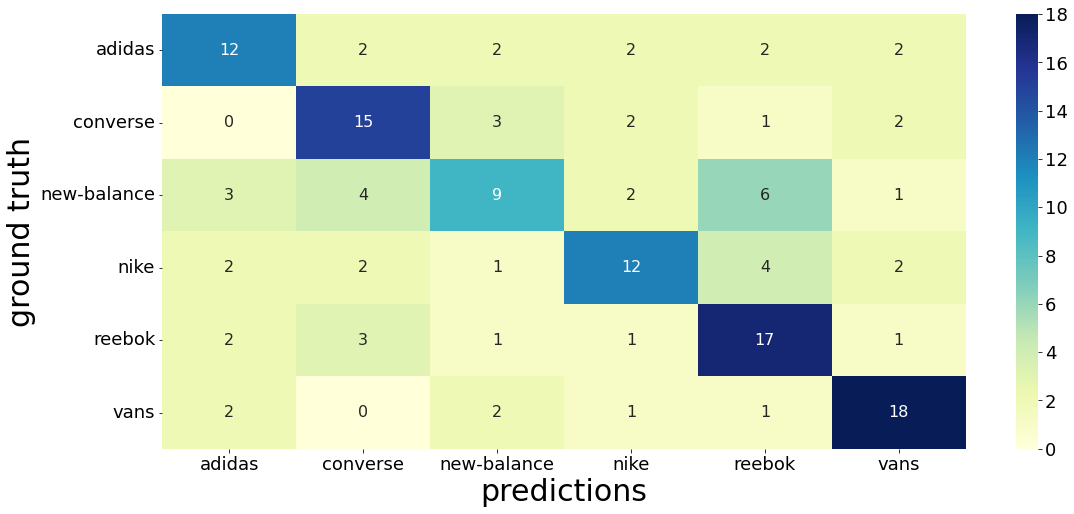

In [22]:
cm = get_confusion_matrix(model,test_loader)
plot_confusion_matrix(cm,class_list)

## Recall, Precision and F1 Score

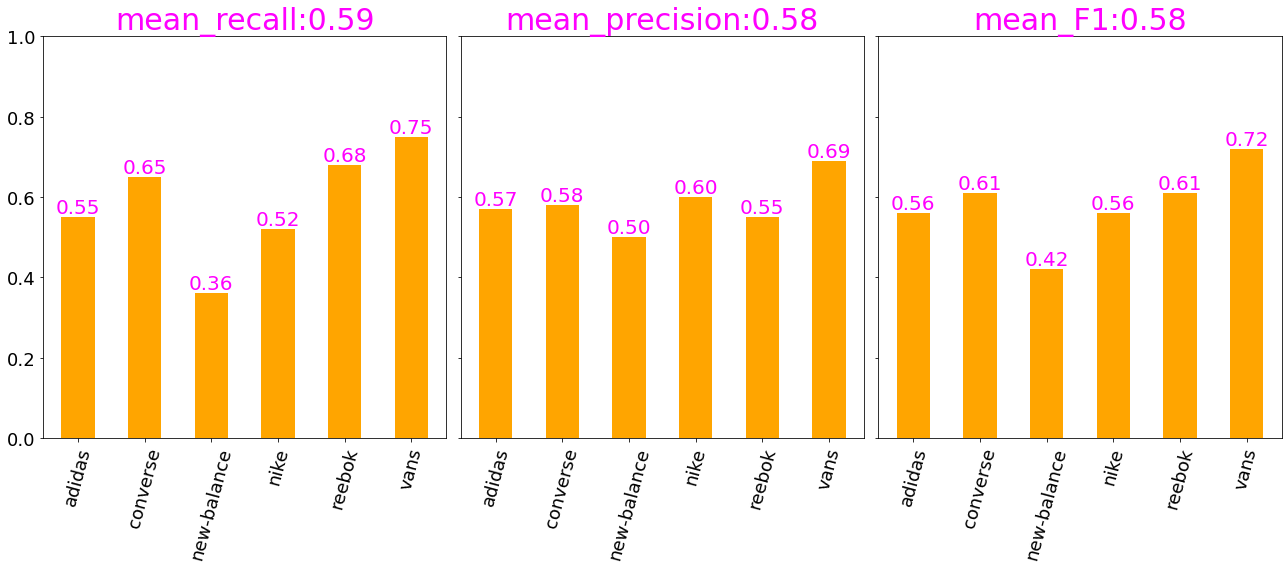

In [23]:
display_all_scores(cm,class_list)

- 0.58 recall for Adidas means: Out of all the **actual 'Adidas' instances** in the dataset, the model correctly identified 58% of them. The remaining 42% were false negatives, meaning that the model failed to identify them as 'Adidas' and classified them other sneakers

- 0.32 precision for Adidas means: Out of all the **instances that the model predicted as 'Adidas'**, only 32% of them were actually 'Adidas'. The remaining 68% of the instances were false positives (i.e., they belong to other sneaker brand but were incorrectly predicted as 'Adidas').
- It is the most CONFUSING class since "others" are constantly classified as Adidas.

# Visualize the Filters and Feature Maps

- This section is a great demonstration why CNNs are key components of image understanding problems. Remember we apply kernels to different channels to obtain feature maps. What we display below are feature maps associated with different layers after the application of the corresponding kernels.


- **Notice that each kernel reveals a different feature about the original image. As the input image flows through the model, the model learns very different aspect of it just like we learn. However, our model is not doing a good job at this point, thus we see that some convolutional layers do not learn anything, they just vanish.**


- In our model, we have three CNN layers with 32,32 and 64 feature maps respectively.Here is the full break-down(kind of);


In [24]:
image_path = test_image_paths[4]
vis_dict,selected_layers = get_all_feature_maps(model,image_path,test_transforms)

2/3 convolutional layers is selected
pick one of these layer numbers to visualize dict_keys([0, 1])


- Layer-2 &rarr; 32 kernals of size 3x3 is applied to our 128x128 RGB image resulting 32 feature maps of size 126x126 below.

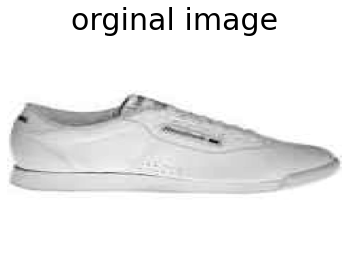

feature map size: 58x58


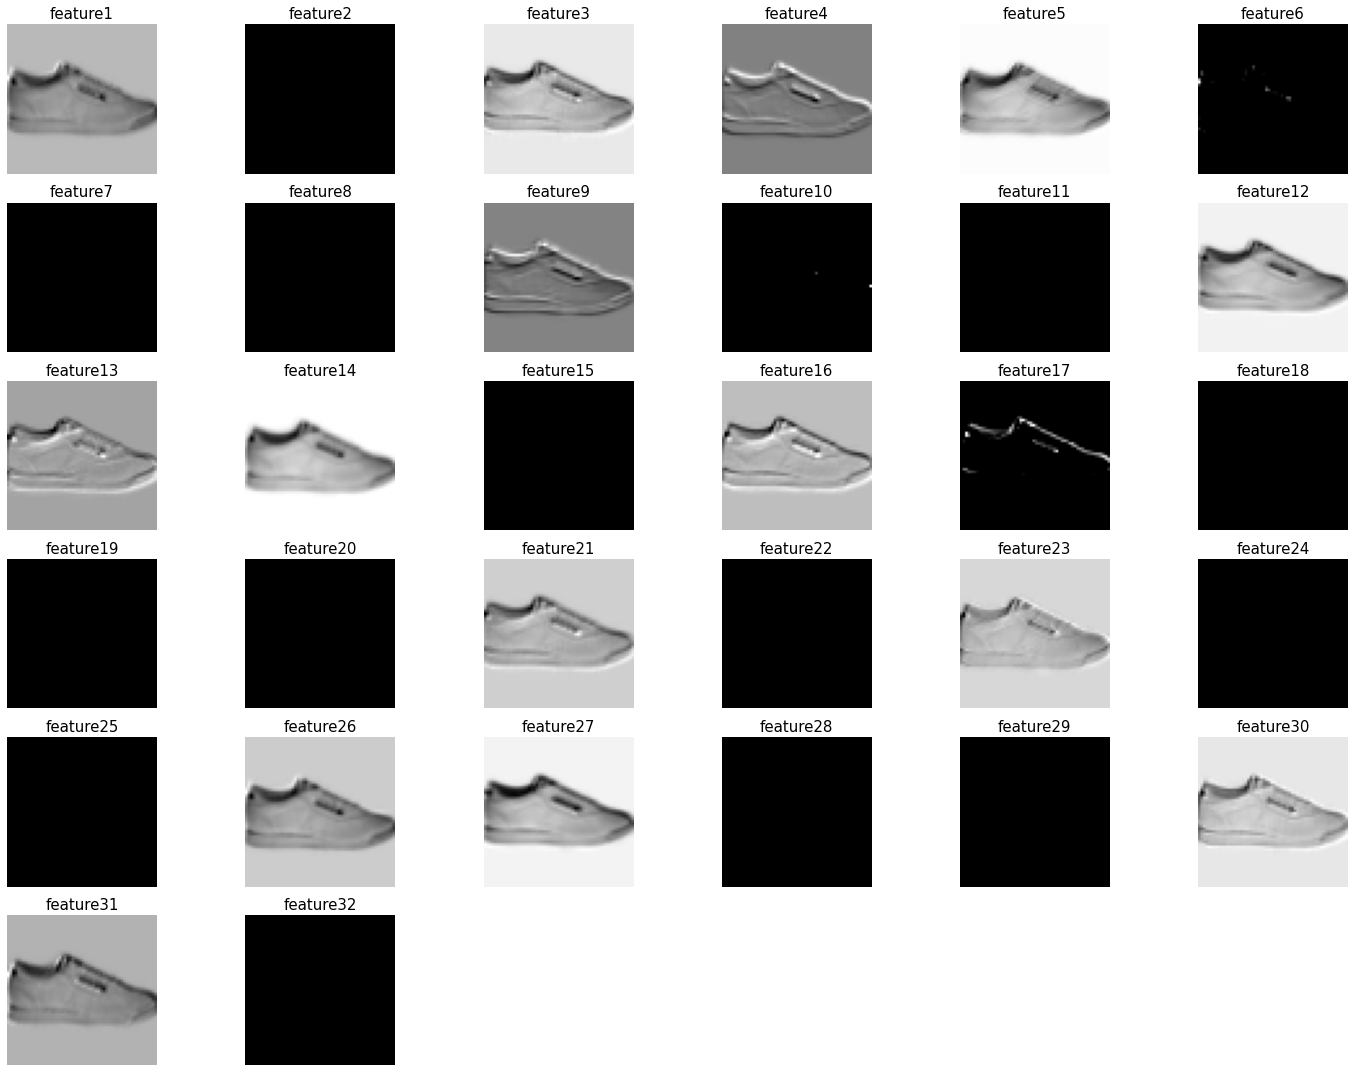

In [25]:
visualize_feature_maps(vis_dict,image_path,layer_num=0)

Layer-1 &rarr; 32 kernals of size 3x3 is applied to our 126x126 feature maps coming from layer-0 resulting 32 feature maps of size 61x61 below.

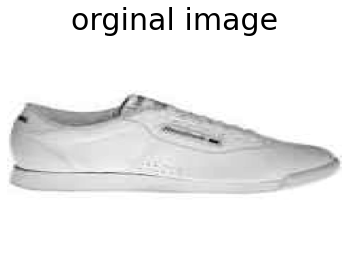

feature map size: 27x27


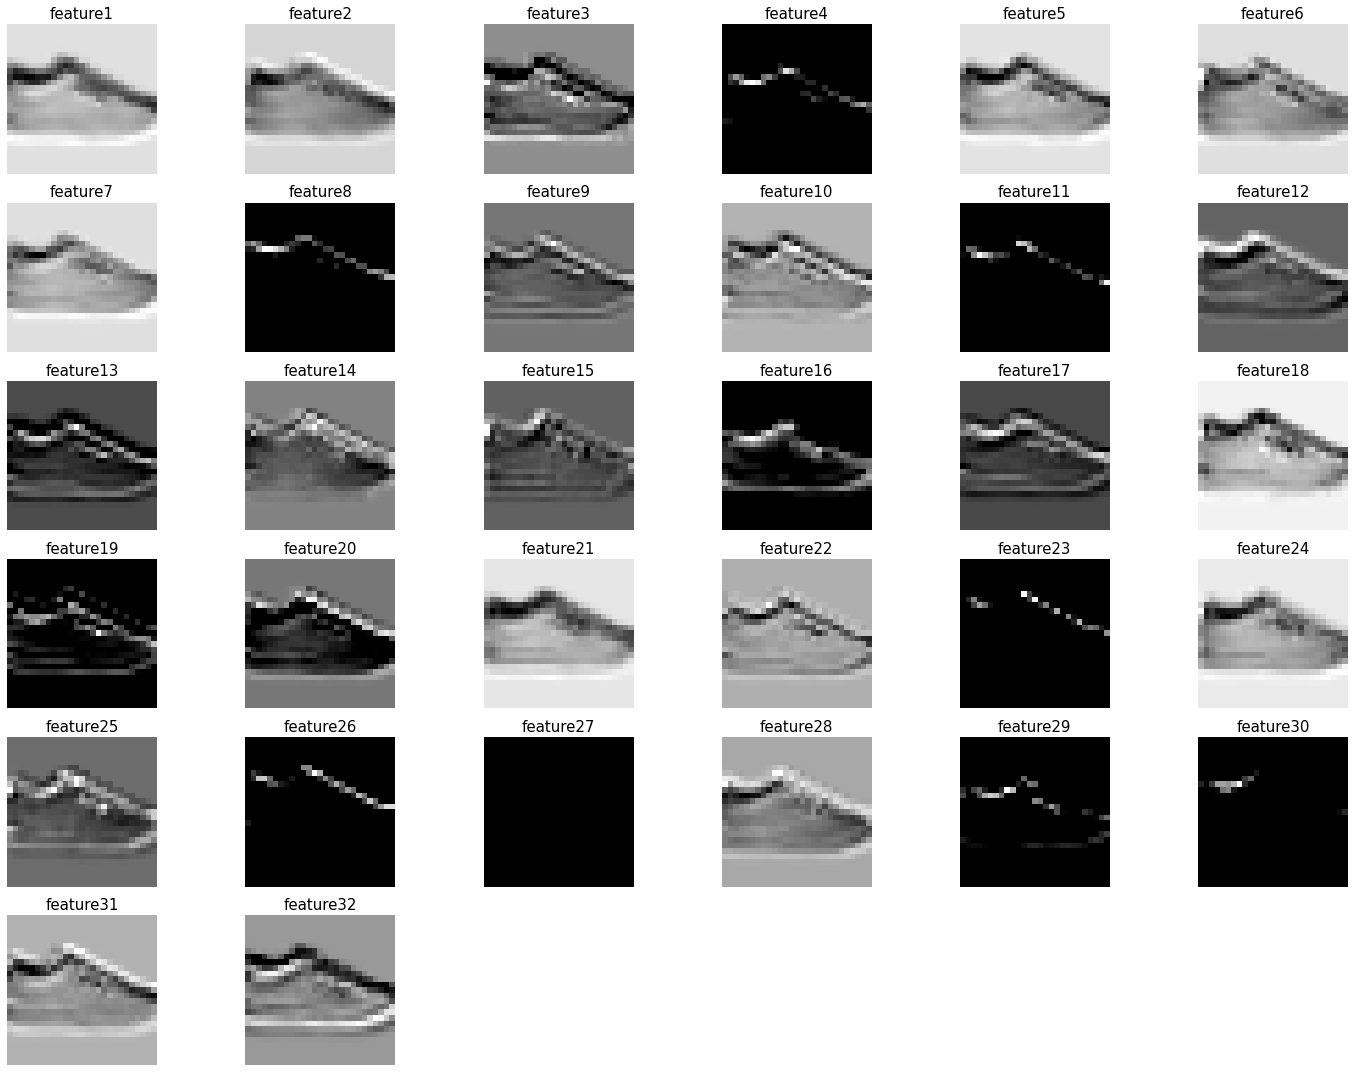

In [26]:
visualize_feature_maps(vis_dict,image_path,layer_num=1)